# 3D Point Cloud Alignment & Error Analysis

## Objective of this Notebook
In this notebook, we load a dataset of synthetic 3D scans (generated in Blender). We use **Open3D** to align (register) these scans to a reference object.

We will perform the following steps:
1.  Load point clouds from CSV files.
2.  Preprocessing: Estimate **Normal Vectors**.
3.  Apply **Point-to-Plane ICP** (Iterative Closest Point).
4.  Collect statistics on accuracy (RMSE and Fitness scores).

---

## Mathematical Background

### 1. Point-to-Plane Error Metric
To align two point clouds, we need to find a transformation matrix $T$ (rotation + translation) that minimizes the distance between points.

In the **Point-to-Plane** method, we do not measure the distance between point $p$ (source) and point $q$ (target). Instead, we measure the distance from point $p$ to the **plane** on which $q$ lies. This plane is defined by $q$ and its normal vector $n_q$.

The error function $E(T)$ to be minimized is:

$$ E(T) = \sum_{(p,q) \in K} ((T p - q) \cdot n_q)^2 $$

Where:
* $p$: A point in the source cloud.
* $q$: The closest point in the target cloud.
* $n_q$: The normal vector of point $q$ (perpendicular to the surface).
* $\cdot$: The dot product.

This allows points to 'slide' along planar surfaces, which typically converges faster and more accurately than point-to-point methods.

### 2. RMSE (Root Mean Square Error)
To evaluate the quality of the alignment, we use the RMSE. This represents the average deviation of the inliers (overlapping points) after alignment:

$$ RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} || T p_i - q_i ||^2} $$

The lower this number, the better the match.

In [1]:
import open3d as o3d
import pandas as pd
import numpy as np
import os
import glob
import copy
import time

print(f"Open3D version: {o3d.__version__}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Open3D version: 0.19.0


## 1. Configuration and Data Loading
We define the file path and load the index file. **Sample 0** will serve as our **Target** (Reference).

In [2]:
# Path to the data
DATA_ROOT = r"C:\Users\RobinSchool\Stichting Hogeschool Utrecht\MNLE Imagine Project - Documents\DataProgram\Blender_Generated_Data"
SCANS_DIR = os.path.join(DATA_ROOT, "scans")
INDEX_FILE = os.path.join(DATA_ROOT, "dataset_index.csv")

# Load CSV index
if os.path.exists(INDEX_FILE):
    df_index = pd.read_csv(INDEX_FILE)
    print(f"Dataset index loaded: {len(df_index)} scans found.")
else:
    print(f"ERROR: Could not find {INDEX_FILE}.")

Dataset index loaded: 50 scans found.


## 2. Helper Functions
Here we define functions to:
1.  Convert CSV data into Open3D format.
2.  Preprocess the point cloud (Estimate Normals).

In [3]:
def load_pcd_from_csv(filepath):
    """Loads CSV (X,Y,Z) into an Open3D PointCloud object."""
    if not os.path.exists(filepath):
        return None
    
    df = pd.read_csv(filepath)
    pcd = o3d.geometry.PointCloud()
    points = df[['X', 'Y', 'Z']].values
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd

def preprocess_point_cloud(pcd, voxel_size=0.05):
    """
    Prepares the cloud:
    1. Downsampling (optional, for speed).
    2. Normal Estimation (Crucial for Point-to-Plane ICP).
    """
    # We skip downsampling to maintain maximum precision on this small dataset,
    # but in production, downsampling is often required.
    pcd_processed = pcd # pcd.voxel_down_sample(voxel_size)

    # Estimate Normals
    # Radius: How far to look for neighbors to determine the plane?
    # Max_nn: Maximum number of neighbors to consider.
    pcd_processed.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)
    )
    return pcd_processed

## 3. Prepare Reference (Target)
We load **Sample 0**. This is our 'Ground Truth' position to which we will try to align all other scans.

In [4]:
# Get Sample 0
ref_filename = df_index.iloc[0]['filename']
ref_path = os.path.join(SCANS_DIR, ref_filename)

print(f"Loading reference: {ref_filename}")
pcd_target = load_pcd_from_csv(ref_path)
pcd_target = preprocess_point_cloud(pcd_target)

# Visual check (paint grey)
pcd_target.paint_uniform_color([0.5, 0.5, 0.5])
print(f"Reference loaded. Number of points: {len(pcd_target.points)}")

Loading reference: scan_0000.csv
Reference loaded. Number of points: 7016


## 4. Alignment Loop (Batch Processing)
We now loop through all other files in the dataset.

For every scan:
1.  Load the Source cloud.
2.  Estimate normals.
3.  Execute **ICP** (Target = Sample 0, Source = Current Sample).
4.  Store the `fitness` (overlap ratio) and `rmse` (average error).

In [5]:
results = []

# ICP Settings
threshold = 0.5 # Max distance (in meters) to consider a point a match.
                # Since we know the translation is max 0.5m, we set this broadly.

print("Starting Batch Alignment...")
start_time = time.time()

# We skip index 0 (that is the target itself)
for idx, row in df_index.iloc[1:].iterrows():
    
    filename = row['filename']
    filepath = os.path.join(SCANS_DIR, filename)
    
    # 1. Load
    pcd_source = load_pcd_from_csv(filepath)
    if pcd_source is None: 
        continue
        
    # 2. Preprocess
    pcd_source = preprocess_point_cloud(pcd_source)
    
    # 3. Execute ICP (Point-to-Plane)
    # We start with the Identity Matrix (assuming they are somewhat close)
    init_transform = np.identity(4)
    
    reg_p2l = o3d.pipelines.registration.registration_icp(
        pcd_source, pcd_target, threshold, init_transform,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=50)
    )
    
    # 4. Save results
    results.append({
        'id': row['id'],
        'filename': filename,
        'fitness': reg_p2l.fitness,      # Score 0.0 to 1.0 (1.0 = perfect overlap)
        'rmse': reg_p2l.inlier_rmse,     # Root Mean Square Error
        'transformation': reg_p2l.transformation # The calculated 4x4 matrix
    })
    
    if idx % 10 == 0:
        print(f"Processed sample {idx}/{len(df_index)-1} - RMSE: {reg_p2l.inlier_rmse:.4f}")

end_time = time.time()
print(f"\nDone! Processed {len(results)} scans in {end_time - start_time:.2f} seconds.")

Starting Batch Alignment...
Processed sample 10/49 - RMSE: 0.0018
Processed sample 20/49 - RMSE: 0.0000
Processed sample 30/49 - RMSE: 0.0018
Processed sample 40/49 - RMSE: 0.0018

Done! Processed 49 scans in 1.33 seconds.


## 5. Statistics and Analysis
We convert the results into a Pandas DataFrame to calculate the average error.

Sample results:


,id,filename,fitness,rmse,transformation
0,1,scan_0001.csv,0.0,0.000000,"[[0.7861734074123168, -0.5866418586352771, -0...."
1,2,scan_0002.csv,1.0,0.001764,"[[0.9001607444538707, 0.07559511387258924, -0...."
2,3,scan_0003.csv,0.0,0.000000,"[[0.001988475514690946, 0.10386580495575048, -..."
3,4,scan_0004.csv,1.0,0.001768,"[[0.6079540266619519, -0.211569084555298, 0.76..."
4,5,scan_0005.csv,0.0,0.000000,"[[-0.5577345718647289, -0.7780251877543232, -0..."



=== FINAL REPORT ===
Total Scans:       49
Mean RMSE:         0.002390 (Lower is better)
Std Dev RMSE:      0.008637
Mean Fitness:      0.4082 (Closer to 1.0 is better)
Plot generated.


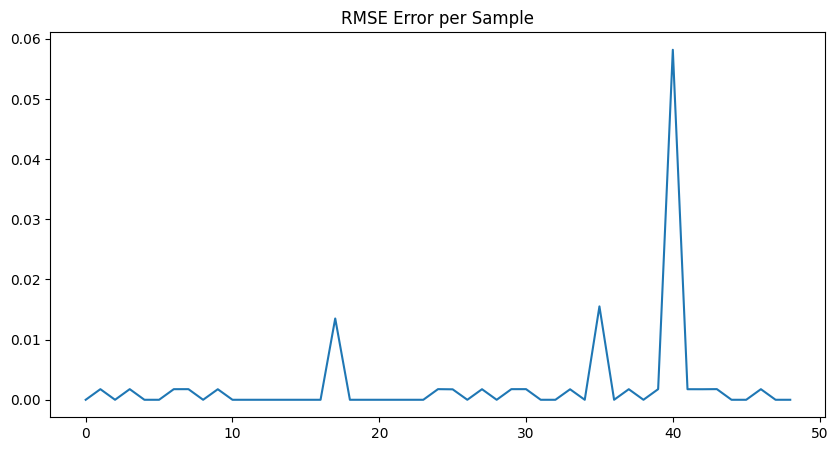

In [6]:
df_results = pd.DataFrame(results)

# Show first few results
print("Sample results:")
display(df_results.head())

# Calculate statistics
mean_rmse = df_results['rmse'].mean()
std_rmse = df_results['rmse'].std()
mean_fitness = df_results['fitness'].mean()

print("\n=== FINAL REPORT ===")
print(f"Total Scans:       {len(df_results)}")
print(f"Mean RMSE:         {mean_rmse:.6f} (Lower is better)")
print(f"Std Dev RMSE:      {std_rmse:.6f}")
print(f"Mean Fitness:      {mean_fitness:.4f} (Closer to 1.0 is better)")

# Simple plot of the errors
try:
    df_results['rmse'].plot(title='RMSE Error per Sample', kind='line', figsize=(10, 5))
    print("Plot generated.")
except:
    print("Could not generate plot (matplotlib required).")

## 6. Visualization (Optional)
Do you want to inspect how a specific scan was aligned? Run this cell.
A **pop-up window** will open. (Press 'q' to close).

In [8]:
def visualize_alignment(sample_id):
    # Find result for this ID
    res = df_results[df_results['id'] == sample_id]
    if res.empty:
        print("ID not found in results.")
        return
        
    # Get Data
    filename = res.iloc[0]['filename']
    trans_matrix = res.iloc[0]['transformation']
    
    print(f"Visualizing Sample {sample_id} ({filename})...")
    
    # Load
    pcd_src = load_pcd_from_csv(os.path.join(SCANS_DIR, filename))
    pcd_src = preprocess_point_cloud(pcd_src)
    
    # Set Colors
    pcd_target_vis = copy.deepcopy(pcd_target)
    pcd_target_vis.paint_uniform_color([0.5, 0.5, 0.5]) # Target = Grey
    
    pcd_src_aligned = copy.deepcopy(pcd_src)
    pcd_src_aligned.transform(trans_matrix)             # Apply calculated alignment
    pcd_src_aligned.paint_uniform_color([1, 0, 0])      # Aligned Source = Red
    
    # Open Window
    o3d.visualization.draw_geometries(
        [pcd_target_vis, pcd_src_aligned],
        window_name=f"Alignment Result Sample {sample_id}",
        width=800, height=600,
        left=50, top=50
    )

# Choose an ID to view (e.g., Sample 5)
visualize_alignment(5)

Visualizing Sample 5 (scan_0005.csv)...
